In [3]:
import pandas as pd
import numpy as np
# from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# For financial data retrieval
import pandas_datareader.data as web

# For date handling
from datetime import datetime

# For sentiment analysis
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch

from alpha_vantage.timeseries import TimeSeries
from fredapi import Fred
from newsapi import NewsApiClient
import requests
import matplotlib.pyplot as plt

import ta  # Technical Analysis library
from sklearn.model_selection import train_test_split

import math
import seaborn as sns
import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset, random_split

import random

# Set random seeds for reproducibility
np.random.seed(42)
# torch.manual_seed(42)
random.seed(42)


In [2]:
combined_df = pd.read_csv('combined_df.csv')
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df

,Date,Open,High,Low,Close,Volume,Crude Oil WTI Futures,Federal Funds Rate,USD/EUR Exchange Rate,USD/GBP Exchange Rate,...,USD/NOK Exchange Rate,USD/SGD Exchange Rate,USD/AUD Exchange Rate,USD/JPY Exchange Rate,USD/INR Exchange Rate,M1 Money Supply,M2 Money Supply,Consumer Price Index (CPI),Producer Price Index (PPI),Unemployment Rate
0,1999-11-01,136.5000,137.0000,135.5625,135.5625,4006500.0,22.44,5.38,1.0494,1.6404,...,7.8770,1.6565,0.6382,104.19,43.51,1110.7,4611.8,168.400,128.300,4.1
1,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0,22.49,5.18,1.0506,1.6445,...,7.8650,1.6645,0.6405,104.15,43.45,1110.7,4611.8,168.400,128.300,4.1
2,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0,22.59,5.21,1.0485,1.6440,...,7.8825,1.6700,0.6437,105.00,43.46,1110.7,4611.8,168.400,128.300,4.1
3,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0,23.17,5.27,1.0440,1.6375,...,7.9120,1.6665,0.6383,104.48,43.45,1110.7,4611.8,168.400,128.300,4.1
4,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0,22.93,5.14,1.0400,1.6205,...,7.9260,1.6715,0.6385,106.33,43.45,1110.7,4611.8,168.400,128.300,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9145,2024-11-20,590.3800,590.7900,584.6300,590.5000,50032576.0,69.81,4.83,1.0848,1.2959,...,11.0471,1.3242,0.6582,152.94,84.03,18237.4,21311.2,315.454,253.452,4.1
9146,2024-11-21,593.4000,595.1200,587.4500,593.6700,46750285.0,69.81,4.83,1.0848,1.2959,...,11.0471,1.3242,0.6582,152.94,84.03,18237.4,21311.2,315.454,253.452,4.1
9147,2024-11-22,593.6600,596.1500,593.1525,595.5100,38226390.0,69.81,4.83,1.0848,1.2959,...,11.0471,1.3242,0.6582,152.94,84.03,18237.4,21311.2,315.454,253.452,4.1
9148,2024-11-25,599.5200,600.8600,595.2000,597.5300,42441393.0,69.81,4.83,1.0848,1.2959,...,11.0471,1.3242,0.6582,152.94,84.03,18237.4,21311.2,315.454,253.452,4.1


In [3]:
combined_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Crude Oil WTI Futures', 'Federal Funds Rate', 'USD/EUR Exchange Rate',
       'USD/GBP Exchange Rate', 'USD/CNY Exchange Rate',
       'USD/NOK Exchange Rate', 'USD/SGD Exchange Rate',
       'USD/AUD Exchange Rate', 'USD/JPY Exchange Rate',
       'USD/INR Exchange Rate', 'M1 Money Supply', 'M2 Money Supply',
       'Consumer Price Index (CPI)', 'Producer Price Index (PPI)',
       'Unemployment Rate'],
      dtype='object')

In [4]:
df = combined_df.copy()

# Ensure the data is sorted by date
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# 1. Candlestick Pattern Classification (13 classes)
eight_trigram_patterns = [
    'BullishHorn', 'BearHorn', 'BullishHigh', 'BearHigh',
    'BullishLow', 'BearLow', 'BullishHarami', 'BearHarami'
]

def classify_eight_trigram(row):
    # Skip the first row as there's no previous day to compare
    if row.name == 0:
        return 'Neutral'

    # Today's and yesterday's high, low, close prices
    ht = row['High']
    lt = row['Low']
    ct = row['Close']

    ht_prev = df.loc[row.name - 1, 'High']
    lt_prev = df.loc[row.name - 1, 'Low']
    ct_prev = df.loc[row.name - 1, 'Close']

    # Apply the eight-trigram conditions
    # 1. BullishHorn
    if (ht > ht_prev) and (lt < lt_prev) and (ct > ct_prev):
        return 'BullishHorn'

    # 2. BearHorn
    elif (ht > ht_prev) and (lt < lt_prev) and (ct < ct_prev):
        return 'BearHorn'

    # 3. BullishHigh
    elif (ht > ht_prev) and (lt > lt_prev) and (ct > ct_prev):
        return 'BullishHigh'

    # 4. BearHigh
    elif (ht > ht_prev) and (lt > lt_prev) and (ct < ct_prev):
        return 'BearHigh'

    # 5. BullishLow
    elif (ht < ht_prev) and (lt < lt_prev) and (ct > ct_prev):
        return 'BullishLow'

    # 6. BearLow
    elif (ht < ht_prev) and (lt < lt_prev) and (ct < ct_prev):
        return 'BearLow'

    # 7. BullishHarami
    elif (ht < ht_prev) and (lt > lt_prev) and (ct > ct_prev):
        return 'BullishHarami'

    # 8. BearHarami
    elif (ht < ht_prev) and (lt > lt_prev) and (ct < ct_prev):
        return 'BearHarami'

    else:
        return 'Neutral'

# Apply the function to classify each row
df['Eight_Trigram_Pattern'] = df.apply(classify_eight_trigram, axis=1)

# Map patterns to numerical codes
df['Eight_Trigram_Code'] = df['Eight_Trigram_Pattern'].map({
    'BullishHorn': 1,
    'BearHorn': 2,
    'BullishHigh': 3,
    'BearHigh': 4,
    'BullishLow': 5,
    'BearLow': 6,
    'BullishHarami': 7,
    'BearHarami': 8,
    'Neutral': 0
})

# 2. Inter-day Price Movement Patterns (Eight-Trigram Scheme)
# Again, we'll use standard definitions due to lack of specifics

def classify_inter_day(row):
    if row.name == 0:
        return 'Neutral'  # No previous day to compare with
    else:
        prev_close = df.loc[row.name - 1, 'Close']
        today_open = row['Open']

        if today_open > prev_close:
            movement = 'Gap Up'
        elif today_open < prev_close:
            movement = 'Gap Down'
        else:
            movement = 'No Gap'

        # Further classification can be added based on High and Low
        return movement



In [5]:
# 1. Custom Functions and Initial Features
df['Inter_Day_Movement'] = df.apply(classify_inter_day, axis=1)
df['Inter_Day_Movement_Code'] = pd.factorize(df['Inter_Day_Movement'])[0]

# 2. Volume Rate of Change
look_back_period = 5  # Adjust based on your analysis needs
n = look_back_period  # Define n based on look_back_period
df['Volume_ROC'] = df['Volume'].pct_change(periods=n) * 100

# 3. Overlap Indicators
## Simple Moving Averages
df['SMA_5'] = ta.trend.SMAIndicator(close=df['Close'], window=5).sma_indicator()
df['SMA_10'] = ta.trend.SMAIndicator(close=df['Close'], window=10).sma_indicator()
# df['SMA_20'] = ta.trend.SMAIndicator(close=df['Close'], window=20).sma_indicator()
df['SMA_30'] = ta.trend.SMAIndicator(close=df['Close'], window=30).sma_indicator()

## Exponential Moving Averages
df['EMA_10'] = ta.trend.EMAIndicator(close=df['Close'], window=10).ema_indicator()
# df['EMA_20'] = ta.trend.EMAIndicator(close=df['Close'], window=20).ema_indicator()
df['EMA_30'] = ta.trend.EMAIndicator(close=df['Close'], window=30).ema_indicator()

## Double Exponential Moving Average (DEMA)
def calculate_dema(series, window):
    ema = ta.trend.EMAIndicator(close=series, window=window).ema_indicator()
    ema_ema = ta.trend.EMAIndicator(close=ema, window=window).ema_indicator()
    dema = 2 * ema - ema_ema
    return dema

df['DEMA_5'] = calculate_dema(df['Close'], window=5)
df['DEMA_30'] = calculate_dema(df['Close'], window=30)

## Triple Exponential Moving Average (TEMA)
def calculate_tema(series, window):
    ema1 = ta.trend.EMAIndicator(close=series, window=window).ema_indicator()
    ema2 = ta.trend.EMAIndicator(close=ema1, window=window).ema_indicator()
    ema3 = ta.trend.EMAIndicator(close=ema2, window=window).ema_indicator()
    tema = 3 * (ema1 - ema2) + ema3
    return tema

df['TEMA_30'] = calculate_tema(df['Close'], window=30)

## Weighted Moving Average (WMA)
df['WMA_30'] = ta.trend.WMAIndicator(close=df['Close'], window=30).wma()

## Kaufman's Adaptive Moving Average (KAMA)
df['KAMA_5'] = ta.momentum.KAMAIndicator(close=df['Close'], window=5).kama()

## Parabolic SAR
psar = ta.trend.PSARIndicator(high=df['High'], low=df['Low'], close=df['Close'])
df['PSAR'] = psar.psar()

## Bollinger Bands
bb = ta.volatility.BollingerBands(close=df['Close'], window=5, window_dev=2)
df['BB_UPPER'] = bb.bollinger_hband()
df['BB_MIDDLE'] = bb.bollinger_mavg()
df['BB_LOWER'] = bb.bollinger_lband()

# 4. Momentum Indicators
## Average Directional Movement Index (ADX)
df['ADX_10'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=10).adx()
# df['ADX_14'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14).adx()

## Commodity Channel Index (CCI)
df['CCI_10'] = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=10).cci()

## Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_SIGNAL'] = macd.macd_signal()
df['MACD_HIST'] = macd.macd_diff()

## Relative Strength Index (RSI)
df['RSI_10'] = ta.momentum.RSIIndicator(close=df['Close'], window=10).rsi()
# df['RSI_14'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

## Money Flow Index (MFI)
df['MFI_10'] = ta.volume.MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=10).money_flow_index()
# df['MFI_14'] = ta.volume.MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=14).money_flow_index()

## Rate of Change (ROC)
df['ROC_10'] = ta.momentum.ROCIndicator(close=df['Close'], window=10).roc()

## Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'])
df['STOCH_%K'] = stoch.stoch()
df['STOCH_%D'] = stoch.stoch_signal()

## Williams %R
df['WILLR_10'] = ta.momentum.WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=10).williams_r()

## Ultimate Oscillator (ULTOSC)
df['ULTOSC'] = ta.momentum.UltimateOscillator(high=df['High'], low=df['Low'], close=df['Close']).ultimate_oscillator()

# Balance of Power (BOP)
df['BOP'] = (df['Close'] - df['Open']) / (df['High'] - df['Low'])
df['BOP'] = df['BOP'].replace([np.inf, -np.inf], np.nan).fillna(0)

## Chande Momentum Oscillator (CMO)
def calculate_cmo(series, window):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    sum_gain = gain.rolling(window=window).sum()
    sum_loss = loss.rolling(window=window).sum()
    cmo = 100 * (sum_gain - sum_loss) / (sum_gain + sum_loss)
    return cmo
df['CMO_10'] = calculate_cmo(df['Close'], window=10)

# 5. Volume Indicators
## Accumulation/Distribution Index (ADI
df['ADI'] = ta.volume.AccDistIndexIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume']).acc_dist_index()

## On-Balance Volume (OBV)
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()

## Chaikin Money Flow (CMF)
def calculate_chaikin_oscillator(high, low, close, volume, fast_period=3, slow_period=10):
    ad = ta.volume.AccDistIndexIndicator(high=high, low=low, close=close, volume=volume).acc_dist_index()
    ema_fast = ta.trend.EMAIndicator(close=ad, window=fast_period).ema_indicator()
    ema_slow = ta.trend.EMAIndicator(close=ad, window=slow_period).ema_indicator()
    adosc = ema_fast - ema_slow
    return adosc
df['ADOSC'] = calculate_chaikin_oscillator(df['High'], df['Low'], df['Close'], df['Volume'])

# 6. Volatility Indicators
## Average True Range (ATR)
df['ATR_10'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=10).average_true_range()
# df['ATR_14'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()

## Normalized Average True Range (NATR)
df['NATR_10'] = (df['ATR_10'] / df['Close']) * 100
# df['NATR_14'] = (df['ATR_14'] / df['Close']) * 100

## True Range (TRANGE)
def calculate_true_range(high, low, close):
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    return tr
df['TRANGE'] = calculate_true_range(df['High'], df['Low'], df['Close'])

# 7. Other Indicators
## Average Price
df['AVGPRICE'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

## Median Price
df['MEDPRICE'] = (df['High'] + df['Low']) / 2

## Typical Price
df['TYPPRICE'] = (df['High'] + df['Low'] + df['Close']) / 3

## Weighted Close Price
df['WCLPRICE'] = (df['High'] + df['Low'] + 2 * df['Close']) / 4

# 8. Lagged Features
# df['Lag_1'] = df['Close'].shift(1)
# df['Lag_2'] = df['Close'].shift(2)

# 9. Returns
df['Return'] = df['Close'].pct_change()

# 10. Rolling Statistics
df['Rolling_Median_10'] = df['Close'].rolling(window=10).median()
df['Rolling_Std_10'] = df['Close'].rolling(window=10).std()
df['Rolling_Median_5'] = df['Close'].rolling(window=5).median()
df['Rolling_Std_5'] = df['Close'].rolling(window=5).std()

# 11. Time-Based Features
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

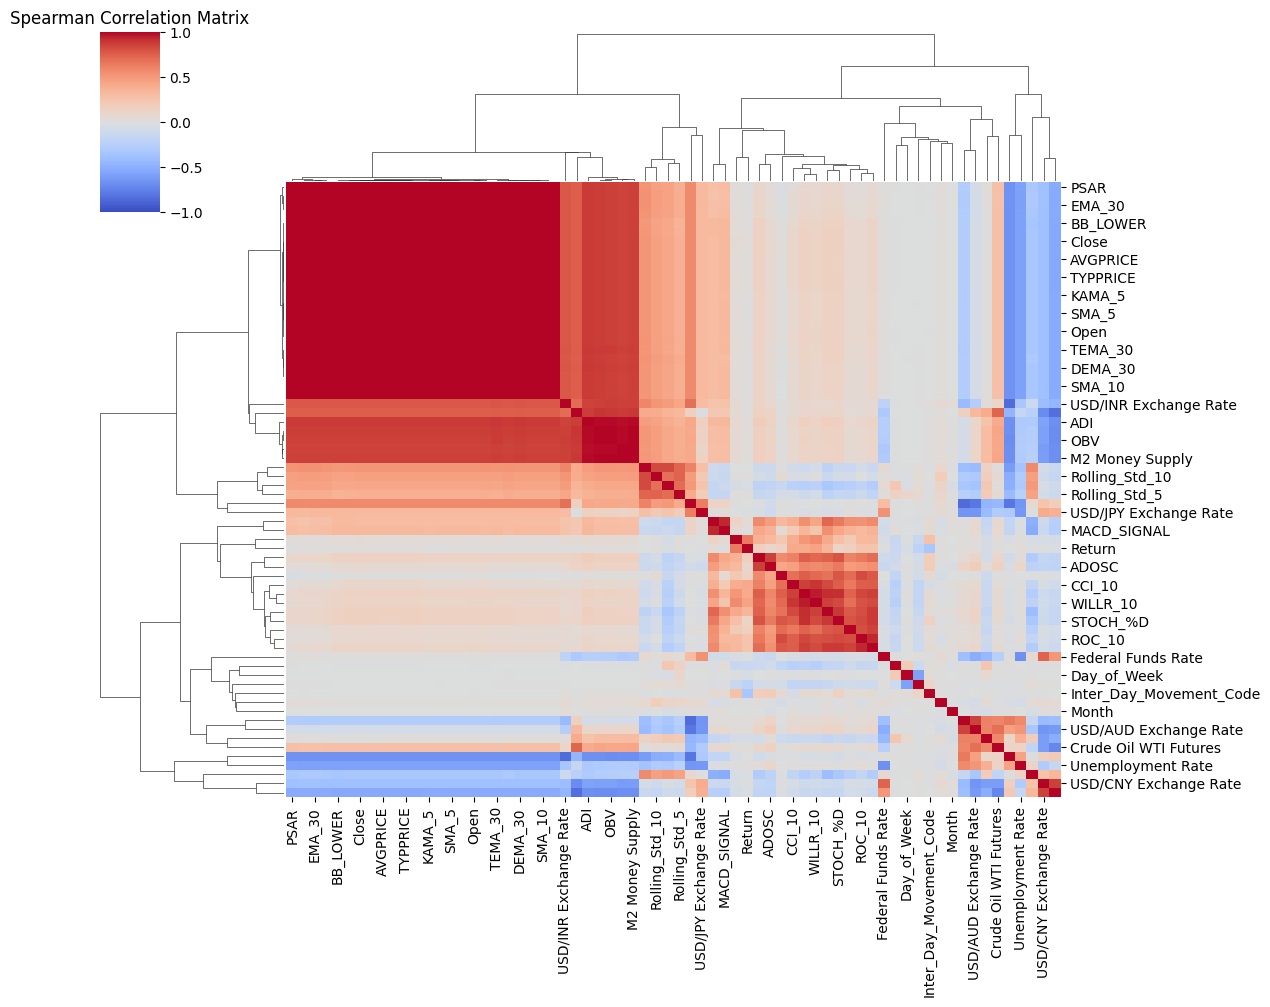

Groups of highly correlated features:
{'EMA_10', 'PSAR', 'MEDPRICE', 'Rolling_Median_10', 'TYPPRICE', 'BB_UPPER', 'WMA_30', 'BB_LOWER', 'WCLPRICE', 'SMA_5', 'DEMA_30', 'Open', 'SMA_30', 'TEMA_30', 'AVGPRICE', 'BB_MIDDLE', 'KAMA_5', 'DEMA_5', 'SMA_10', 'Rolling_Median_5', 'Low', 'EMA_30', 'High'}
{'ADI', 'Consumer Price Index (CPI)', 'M1 Money Supply', 'OBV', 'M2 Money Supply'}
{'MACD_SIGNAL', 'MACD'}
{'RSI_10', 'STOCH_%K', 'STOCH_%D', 'WILLR_10'}
{'ROC_10', 'CMO_10'}
Index(['Close', 'Volume', 'Crude Oil WTI Futures', 'Federal Funds Rate',
       'USD/EUR Exchange Rate', 'USD/GBP Exchange Rate',
       'USD/CNY Exchange Rate', 'USD/NOK Exchange Rate',
       'USD/SGD Exchange Rate', 'USD/AUD Exchange Rate',
       'USD/JPY Exchange Rate', 'USD/INR Exchange Rate',
       'Producer Price Index (PPI)', 'Unemployment Rate', 'Eight_Trigram_Code',
       'Inter_Day_Movement_Code', 'Volume_ROC', 'EMA_10', 'ADX_10', 'CCI_10',
       'MACD_SIGNAL', 'MACD_HIST', 'RSI_10', 'MFI_10', 'ROC_10', 'ULT

In [6]:
# Select only numeric columns
spearman_df = df.select_dtypes(include=[np.number])

# Calculate the Spearman correlation matrix
corr_matrix = spearman_df.corr(method='spearman')

# Set a threshold for high correlation
threshold = 0.90

# Create a mask to identify highly correlated features
high_corr_var = np.where(np.abs(corr_matrix) > threshold)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

# Create a graph to group highly correlated features
G = nx.Graph()
G.add_edges_from(high_corr_var)

# Find connected components (groups of highly correlated features)
groups = list(nx.connected_components(G))

# Manually specify which feature to keep from the first group
features_to_remove = set()
for group in groups:
    if 'Close' in group:
        group.remove('Close')
    features_to_remove.update(list(group)[1:])  # Keep one feature from each group

spearman_df.drop(columns=features_to_remove, inplace=True)

# Visualize the correlation matrix using a clustermap without annotations
sns.clustermap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, figsize=(12, 10))
plt.title('Spearman Correlation Matrix')
plt.show()

# Print the groups of highly correlated features
print("Groups of highly correlated features:")
for group in groups:
    print(group)

print(spearman_df.columns)

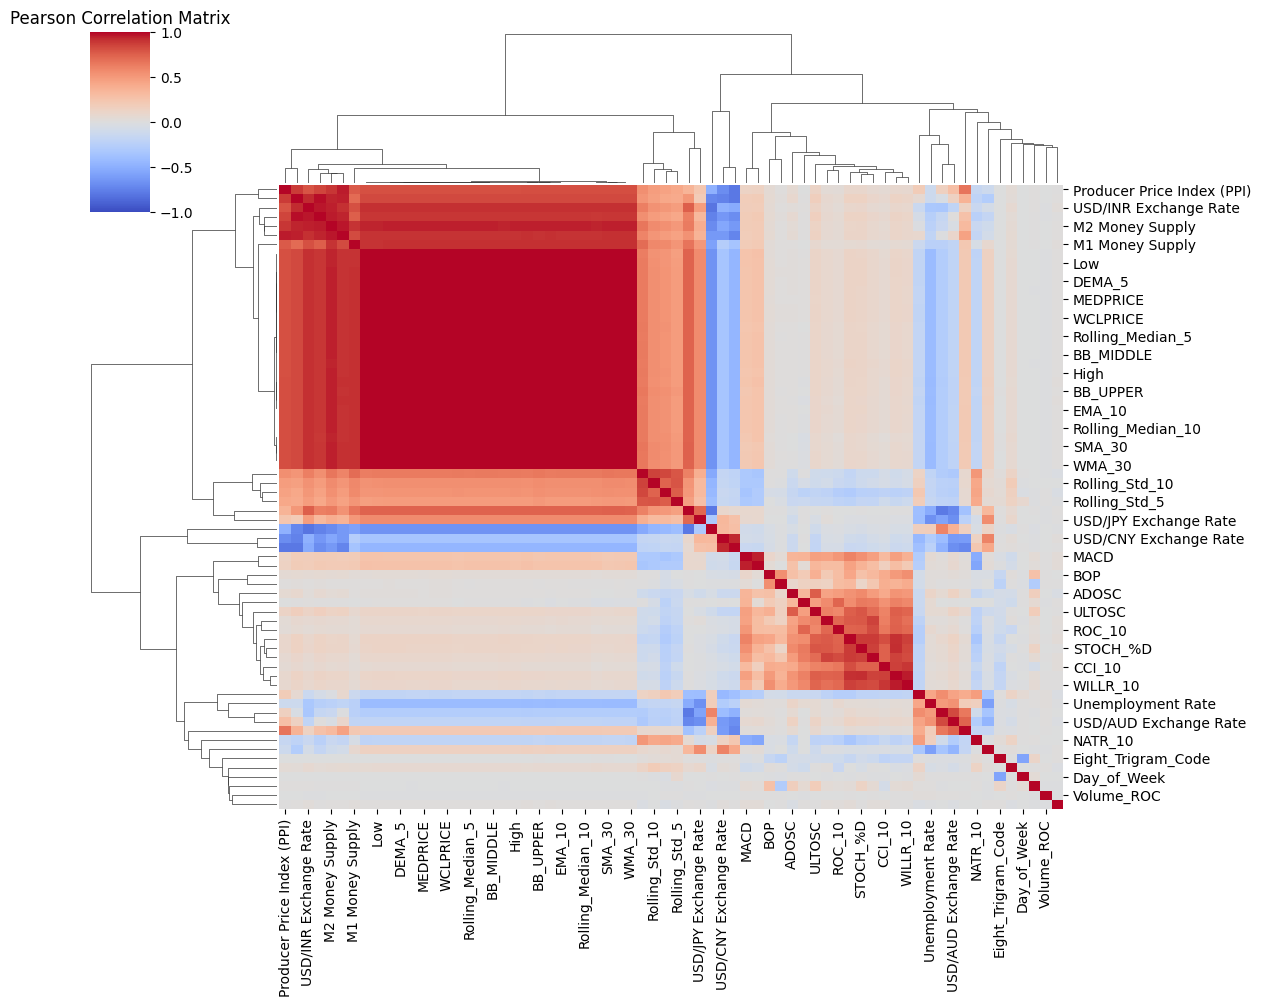

Groups of highly correlated features:
{'Low', 'BB_MIDDLE', 'EMA_10', 'AVGPRICE', 'WMA_30', 'MEDPRICE', 'TEMA_30', 'SMA_5', 'DEMA_30', 'KAMA_5', 'PSAR', 'BB_UPPER', 'SMA_10', 'WCLPRICE', 'Open', 'Rolling_Median_10', 'TYPPRICE', 'Close', 'SMA_30', 'EMA_30', 'Rolling_Median_5', 'BB_LOWER', 'High', 'DEMA_5'}
{'ADI', 'Producer Price Index (PPI)', 'OBV', 'USD/INR Exchange Rate', 'M2 Money Supply', 'Consumer Price Index (CPI)'}
{'MACD', 'MACD_SIGNAL'}
{'STOCH_%K', 'WILLR_10'}


In [ ]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the Spearman correlation matrix
corr_matrix = numeric_df.corr(method='pearson')

# Set a threshold for high correlation
threshold = 0.95

# Create a mask to identify highly correlated features
high_corr_var = np.where(np.abs(corr_matrix) > threshold)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

# Create a graph to group highly correlated features
G = nx.Graph()
G.add_edges_from(high_corr_var)

# Find connected components (groups of highly correlated features)
groups = list(nx.connected_components(G))

# Remove one feature from each highly correlated group
features_to_remove = set()
for group in groups:
    features_to_remove.update(list(group)[1:])  # Keep one feature from each group

numeric_df.drop(columns=features_to_remove, inplace=True)

# Visualize the correlation matrix using a clustermap without annotations
sns.clustermap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, figsize=(12, 10))
plt.title('Pearson Correlation Matrix')
plt.show()

# Print the groups of highly correlated features
print("Groups of highly correlated features:")
for group in groups:
    print(group)

In [4]:
# Determine the number of columns and rows for the grid layout
columns_per_row = 3  # Number of subplots per row
total_columns = [col for col in df.columns if col != 'Date']  # Exclude the 'Date' column
total_plots = len(total_columns)
rows = math.ceil(total_plots / columns_per_row)  # Calculate number of rows needed

# Create the grid layout for subplots
fig, axes = plt.subplots(rows, columns_per_row, figsize=(15, rows * 4), sharex=True)
axes = axes.flatten()  # Flatten axes array for easy indexing

# Plot each column in a separate subplot
for i, column in enumerate(total_columns):
    ax = axes[i]
    ax.plot(df['Date'], df[column], linewidth=1)
    ax.set_title(column, fontsize=12)
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel(column, fontsize=10)
    ax.grid(True)

# Remove empty subplots if the number of plots is not a perfect multiple of columns_per_row
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Time Series of All Columns", fontsize=16, y=1.02)  # Add an overall title
plt.show()


NameError: name 'df' is not defined

In [8]:
# Add a small constant to avoid log(0) or log of negative values
epsilon = 1e-10

# Log transformation for numerical columns except 'Close', 'Date', 'Day_of_Week', and 'Month'
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Close')
if 'Day_of_Week' in numerical_cols:
	numerical_cols.remove('Day_of_Week')
if 'Month' in numerical_cols:
	numerical_cols.remove('Month')

# Check for negative or zero values and shift if necessary
negative_cols = [col for col in numerical_cols if (df[col] + epsilon <= 0).any()]
for col in negative_cols:
    min_val = df[col].min()
    df[col] = df[col] - min_val + 1  # Shift to make all values positive

# Apply log transformation
df[numerical_cols] = df[numerical_cols].apply(lambda x: np.log1p(x + epsilon))

# Sine and cosine transformation for 'Day_of_Week' and 'Month'
df['Day_of_Week_sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
df['Day_of_Week_cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df.drop(['Day_of_Week', 'Month'], axis=1, inplace=True)

# One-hot encoding for categorical columns
categorical_cols = ['Eight_Trigram_Pattern', 'Inter_Day_Movement']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)  # drop_first=True to avoid dummy variable trap

In [9]:
# Check for negative values after log transformation
for col in numerical_cols:
    if (df[col] <= 0).any():
        print(f'Non-positive values found in {col} after log transformation.')

In [10]:
# Handle missing values if any
if df.isnull().values.any():
    df = df.dropna().reset_index(drop=True)

In [11]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Crude Oil WTI Futures', 'Federal Funds Rate', 'USD/EUR Exchange Rate',
       'USD/GBP Exchange Rate', 'USD/CNY Exchange Rate',
       'USD/NOK Exchange Rate', 'USD/SGD Exchange Rate',
       'USD/AUD Exchange Rate', 'USD/JPY Exchange Rate',
       'USD/INR Exchange Rate', 'M1 Money Supply', 'M2 Money Supply',
       'Consumer Price Index (CPI)', 'Producer Price Index (PPI)',
       'Unemployment Rate', 'Eight_Trigram_Code', 'Inter_Day_Movement_Code',
       'Volume_ROC', 'SMA_5', 'SMA_10', 'SMA_30', 'EMA_10', 'EMA_30', 'DEMA_5',
       'DEMA_30', 'TEMA_30', 'WMA_30', 'KAMA_5', 'PSAR', 'BB_UPPER',
       'BB_MIDDLE', 'BB_LOWER', 'ADX_10', 'CCI_10', 'MACD', 'MACD_SIGNAL',
       'MACD_HIST', 'RSI_10', 'MFI_10', 'ROC_10', 'STOCH_%K', 'STOCH_%D',
       'WILLR_10', 'ULTOSC', 'BOP', 'CMO_10', 'ADI', 'OBV', 'ADOSC', 'ATR_10',
       'NATR_10', 'TRANGE', 'AVGPRICE', 'MEDPRICE', 'TYPPRICE', 'WCLPRICE',
       'Return', 'Rolling_

In [18]:
# Step 1: Filter the DataFrame with selected features
features_set1 = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df_set1 = df[features_set1].copy()

# Step 2: Save the filtered DataFrame to a CSV file
# df_set1.to_csv('data_set1.csv', index=False)

In [19]:
# Step 1: Filter the DataFrame with selected features
features_set2 = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Crude Oil WTI Futures', 'Federal Funds Rate', 'USD/EUR Exchange Rate',
       'USD/GBP Exchange Rate', 'USD/CNY Exchange Rate',
       'USD/NOK Exchange Rate', 'USD/SGD Exchange Rate',
       'USD/AUD Exchange Rate', 'USD/JPY Exchange Rate',
       'USD/INR Exchange Rate', 'M1 Money Supply', 'M2 Money Supply',
       'Consumer Price Index (CPI)', 'Producer Price Index (PPI)',
       'Unemployment Rate']
df_set2 = df[features_set2].copy()

# Step 2: Save the filtered DataFrame to a CSV file
# df_set2.to_csv('data_set2.csv', index=False)

In [20]:
# Step 1: Filter the DataFrame with selected features
df_set3 = df.copy()

# Step 2: Save the filtered DataFrame to a CSV file
# df_set3.to_csv('data_set3.csv', index=False)

In [25]:
# Remove 'Day_of_Week' and 'Month' from features_set4 if they exist
features_set4 = spearman_df.columns.tolist()
features_to_remove = ['Day_of_Week', 'Month']
features_set4 = [feature for feature in features_set4 if feature not in features_to_remove]

# Create df_set4 with the updated features_set4
df_set4 = df[features_set4].copy()
df_set4

# # Step 2: Save the filtered DataFrame to a CSV file
# df_set4.to_csv('data_set4.csv', index=False)

,Close,Volume,Crude Oil WTI Futures,Federal Funds Rate,USD/EUR Exchange Rate,USD/GBP Exchange Rate,USD/CNY Exchange Rate,USD/NOK Exchange Rate,USD/SGD Exchange Rate,USD/AUD Exchange Rate,...,ULTOSC,BOP,OBV,ADOSC,ATR_10,NATR_10,TRANGE,Return,Rolling_Std_10,Rolling_Std_5
0,140.2500,16.206354,4.192680,1.888584,0.687632,0.969376,2.227678,2.213481,0.990656,0.503801,...,3.821572,0.959616,19.257334,20.577204,1.326560,1.089793,1.628004,0.744519,1.224351,1.009692
1,135.8750,16.293409,4.193435,1.884035,0.681328,0.963556,2.227657,2.226783,0.996949,0.486430,...,3.683737,0.794711,19.204338,20.573591,1.377035,1.157126,1.743759,0.731516,1.439728,1.199293
2,135.8750,16.293409,4.193435,1.884035,0.681328,0.963556,2.227657,2.226783,0.996949,0.486430,...,3.574844,0.794711,19.257334,20.568578,1.415841,1.192767,1.710423,0.746415,1.477553,1.353791
3,135.8750,16.293409,4.193435,1.884035,0.681328,0.963556,2.227657,2.226783,0.996949,0.486430,...,3.475566,0.794711,19.307662,20.563428,1.449524,1.223794,1.710423,0.746415,1.513267,1.269220
4,139.5625,16.192154,4.199155,1.927164,0.680923,0.962487,2.227614,2.230122,0.993622,0.493598,...,3.759485,1.335708,19.351062,20.566290,1.482094,1.234811,1.735507,0.759198,1.447393,1.169799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9058,590.5000,17.728185,4.689419,1.763017,0.734673,0.831125,2.094503,2.488824,0.843376,0.505733,...,4.059976,1.105085,26.495913,20.601086,1.944023,0.700050,1.968510,0.746575,1.715791,1.345754
9059,593.6700,17.660331,4.689419,1.763017,0.734673,0.831125,2.094503,2.488824,0.843376,0.505733,...,4.127866,1.110278,26.496058,20.618153,1.967829,0.711376,2.159869,0.748956,1.704893,1.373206
9060,595.5100,17.459037,4.689419,1.763017,0.734673,0.831125,2.094503,2.488824,0.843376,0.505733,...,4.155040,1.285695,26.496177,20.629002,1.922694,0.683382,1.385669,0.747883,1.657922,1.368992
9061,597.5300,17.563635,4.689419,1.763017,0.734673,0.831125,2.094503,2.488824,0.843376,0.505733,...,4.161686,0.973959,26.496309,20.626094,1.920068,0.680188,1.896119,0.748022,1.624865,1.421766


In [ ]:
# Remove 'Day_of_Week' and 'Month' from features_set4 if they exist
# features_set5 = ['MEDPRICE', 'M1 Money Supply', 'OBV', 'Unemployment Rate',
#               'Federal Funds Rate', 'Open', 'USD/INR Exchange Rate', 'M2 Money Supply',
#               'USD/NOK Exchange Rate', 'ATR_10', 'Close']

# features_set5 = ['Open', 'High', 'Low', 'Volume', 'Crude Oil WTI Futures',
# 'Federal Funds Rate', 'USD/EUR Exchange Rate', 'USD/GBP Exchange Rate',
# 'USD/CNY Exchange Rate', 'USD/NOK Exchange Rate']

features_set5 = ['Date', 'Rolling_Median_10', 'WMA_30', 'SMA_5', 'TYPPRICE', 'Open', 'BB_MIDDLE', 'SMA_30', 'EMA_30', 'DEMA_30', 'AVGPRICE']

# Create df_set4 with the updated features_set4
df_set5 = df[features_set5].copy()
df_set5
# df_set5['Date'] = pd.to_datetime(df_set5['Date'])
# df.set_index('Date', inplace=True)
# # Step 2: Save the filtered DataFrame to a CSV file
# df_set5.to_csv('data_set5.csv', index=False)

,Rolling_Median_10,WMA_30,SMA_5,TYPPRICE,Open,BB_MIDDLE,SMA_30,EMA_30,DEMA_30,AVGPRICE
Date,,,,,,,,,,
2000-01-27,4.979746,4.977350,4.959737,4.950162,4.961751,4.959737,4.980215,4.976033,4.975475,4.953072
2000-01-28,4.971115,4.973505,4.947651,4.928385,4.944763,4.947651,4.977707,4.972454,4.968569,4.932505
2000-01-29,4.958464,4.969808,4.941285,4.928385,4.944763,4.941285,4.975231,4.969094,4.962283,4.932505
2000-01-30,4.952852,4.966259,4.932584,4.928385,4.944763,4.932584,4.972695,4.965941,4.956573,4.932505
2000-01-31,4.950863,4.964525,4.930780,4.935036,4.918611,4.930780,4.971006,4.964645,4.954647,4.930955
...,...,...,...,...,...,...,...,...,...,...
2024-11-20,6.389368,6.376042,6.381156,6.379512,6.382459,6.381156,6.372424,6.372977,6.384943,6.380250
2024-11-21,6.387738,6.377051,6.381264,6.385329,6.387552,6.381264,6.373071,6.373953,6.386044,6.385886
2024-11-22,6.387738,6.378220,6.384564,6.390136,6.387990,6.384564,6.373820,6.375068,6.387400,6.389600


In [5]:
df_set4 = pd.read_csv('data_set4.csv')
# combined_df['Date'] = pd.to_datetime(combined_df['Date'])
df_set4

,Close,Volume,Crude Oil WTI Futures,Federal Funds Rate,USD/EUR Exchange Rate,USD/GBP Exchange Rate,USD/CNY Exchange Rate,USD/NOK Exchange Rate,USD/SGD Exchange Rate,USD/AUD Exchange Rate,...,ULTOSC,BOP,OBV,ADOSC,ATR_10,NATR_10,TRANGE,Return,Rolling_Std_10,Rolling_Std_5
0,140.2500,16.206354,4.192680,1.888584,0.687632,0.969376,2.227678,2.213481,0.990656,0.503801,...,3.821572,0.959616,19.257334,20.577204,1.326560,1.089793,1.628004,0.744519,1.224351,1.009692
1,135.8750,16.293409,4.193435,1.884035,0.681328,0.963556,2.227657,2.226783,0.996949,0.486430,...,3.683737,0.794711,19.204338,20.573591,1.377035,1.157126,1.743759,0.731516,1.439728,1.199293
2,135.8750,16.293409,4.193435,1.884035,0.681328,0.963556,2.227657,2.226783,0.996949,0.486430,...,3.574844,0.794711,19.257334,20.568578,1.415841,1.192767,1.710423,0.746415,1.477553,1.353791
3,135.8750,16.293409,4.193435,1.884035,0.681328,0.963556,2.227657,2.226783,0.996949,0.486430,...,3.475566,0.794711,19.307662,20.563428,1.449524,1.223794,1.710423,0.746415,1.513267,1.269220
4,139.5625,16.192154,4.199155,1.927164,0.680923,0.962487,2.227614,2.230122,0.993622,0.493598,...,3.759485,1.335708,19.351062,20.566290,1.482094,1.234811,1.735507,0.759198,1.447393,1.169799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9058,590.5000,17.728185,4.689419,1.763017,0.734673,0.831125,2.094503,2.488824,0.843376,0.505733,...,4.059976,1.105085,26.495913,20.601086,1.944023,0.700050,1.968510,0.746575,1.715791,1.345754
9059,593.6700,17.660331,4.689419,1.763017,0.734673,0.831125,2.094503,2.488824,0.843376,0.505733,...,4.127866,1.110278,26.496058,20.618153,1.967829,0.711376,2.159869,0.748956,1.704893,1.373206
9060,595.5100,17.459037,4.689419,1.763017,0.734673,0.831125,2.094503,2.488824,0.843376,0.505733,...,4.155040,1.285695,26.496177,20.629002,1.922694,0.683382,1.385669,0.747883,1.657922,1.368992
9061,597.5300,17.563635,4.689419,1.763017,0.734673,0.831125,2.094503,2.488824,0.843376,0.505733,...,4.161686,0.973959,26.496309,20.626094,1.920068,0.680188,1.896119,0.748022,1.624865,1.421766


In [7]:
df = df_set4.copy()
# df.set_index('Date', inplace=True)
df

,Close,Volume,Crude Oil WTI Futures,Federal Funds Rate,USD/EUR Exchange Rate,USD/GBP Exchange Rate,USD/CNY Exchange Rate,USD/NOK Exchange Rate,USD/SGD Exchange Rate,USD/AUD Exchange Rate,...,ULTOSC,BOP,OBV,ADOSC,ATR_10,NATR_10,TRANGE,Return,Rolling_Std_10,Rolling_Std_5
0,140.2500,16.206354,4.192680,1.888584,0.687632,0.969376,2.227678,2.213481,0.990656,0.503801,...,3.821572,0.959616,19.257334,20.577204,1.326560,1.089793,1.628004,0.744519,1.224351,1.009692
1,135.8750,16.293409,4.193435,1.884035,0.681328,0.963556,2.227657,2.226783,0.996949,0.486430,...,3.683737,0.794711,19.204338,20.573591,1.377035,1.157126,1.743759,0.731516,1.439728,1.199293
2,135.8750,16.293409,4.193435,1.884035,0.681328,0.963556,2.227657,2.226783,0.996949,0.486430,...,3.574844,0.794711,19.257334,20.568578,1.415841,1.192767,1.710423,0.746415,1.477553,1.353791
3,135.8750,16.293409,4.193435,1.884035,0.681328,0.963556,2.227657,2.226783,0.996949,0.486430,...,3.475566,0.794711,19.307662,20.563428,1.449524,1.223794,1.710423,0.746415,1.513267,1.269220
4,139.5625,16.192154,4.199155,1.927164,0.680923,0.962487,2.227614,2.230122,0.993622,0.493598,...,3.759485,1.335708,19.351062,20.566290,1.482094,1.234811,1.735507,0.759198,1.447393,1.169799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9058,590.5000,17.728185,4.689419,1.763017,0.734673,0.831125,2.094503,2.488824,0.843376,0.505733,...,4.059976,1.105085,26.495913,20.601086,1.944023,0.700050,1.968510,0.746575,1.715791,1.345754
9059,593.6700,17.660331,4.689419,1.763017,0.734673,0.831125,2.094503,2.488824,0.843376,0.505733,...,4.127866,1.110278,26.496058,20.618153,1.967829,0.711376,2.159869,0.748956,1.704893,1.373206
9060,595.5100,17.459037,4.689419,1.763017,0.734673,0.831125,2.094503,2.488824,0.843376,0.505733,...,4.155040,1.285695,26.496177,20.629002,1.922694,0.683382,1.385669,0.747883,1.657922,1.368992
9061,597.5300,17.563635,4.689419,1.763017,0.734673,0.831125,2.094503,2.488824,0.843376,0.505733,...,4.161686,0.973959,26.496309,20.626094,1.920068,0.680188,1.896119,0.748022,1.624865,1.421766


In [8]:
# Time series train-test split
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

print("Training data from:", train_df.index[0], "to:", train_df.index[-1])
print("Testing data from:", test_df.index[0], "to:", test_df.index[-1])

# Separate features and target
feature_cols = df.select_dtypes(include=[np.number]).columns.drop(['Close'])
X_train_features = train_df[feature_cols]
X_test_features = test_df[feature_cols]
y_train = train_df['Close']
y_test = test_df['Close']

# Standardization
scaler = StandardScaler()
scaler.fit(X_train_features)
scaled_X_train = scaler.fit_transform(X_train_features)
scaled_X_test = scaler.transform(X_test_features)

#added scaling to y_features as well (Close price)
target_scaler = StandardScaler()
scaled_y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
scaled_y_test = target_scaler.transform(y_test.values.reshape(-1, 1))

# Convert scaled features back to DataFrame for consistency
scaled_train_df = pd.DataFrame(scaled_X_train, columns=feature_cols, index=X_train_features.index)
scaled_test_df = pd.DataFrame(scaled_X_test, columns=feature_cols, index=X_test_features.index)

# Store model parameters and scalers
model_params = {
    'feature_scaler': scaler,          
    'target_scaler': target_scaler,                 
    'feature_columns': feature_cols   
}

Training data from: 0 to: 7249
Testing data from: 7250 to: 9062


In [9]:
# Impute monthly data using forward fill
for column in scaled_test_df.columns:
    scaled_test_df[column] = scaled_test_df[column].ffill()

# Impute monthly data using forward fill
for column in scaled_train_df.columns:
    scaled_train_df[column] = scaled_train_df[column].ffill()

In [10]:
print("DataFrame shape after preprocessing:", scaled_train_df.shape)
# print("\nColumns after preprocessing:", scaled_train_df.columns.tolist())
print("\nSize of dataset", scaled_train_df.size)

print("DataFrame shape after preprocessing:", scaled_test_df.shape)
print("\nColumns after preprocessing:", scaled_test_df.columns.tolist())
print("\nSize of dataset", scaled_test_df.size)

DataFrame shape after preprocessing: (7250, 34)

Size of dataset 246500
DataFrame shape after preprocessing: (1813, 34)

Columns after preprocessing: ['Volume', 'Crude Oil WTI Futures', 'Federal Funds Rate', 'USD/EUR Exchange Rate', 'USD/GBP Exchange Rate', 'USD/CNY Exchange Rate', 'USD/NOK Exchange Rate', 'USD/SGD Exchange Rate', 'USD/AUD Exchange Rate', 'USD/JPY Exchange Rate', 'USD/INR Exchange Rate', 'Producer Price Index (PPI)', 'Unemployment Rate', 'Eight_Trigram_Code', 'Inter_Day_Movement_Code', 'Volume_ROC', 'BB_UPPER', 'ADX_10', 'CCI_10', 'MACD', 'MACD_HIST', 'MFI_10', 'ROC_10', 'WILLR_10', 'ULTOSC', 'BOP', 'OBV', 'ADOSC', 'ATR_10', 'NATR_10', 'TRANGE', 'Return', 'Rolling_Std_10', 'Rolling_Std_5']

Size of dataset 61642


In [78]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# Assume df is your DataFrame already loaded

# Time series train-test split on df_set5
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print("Training data from:", train_df.index[0], "to:", train_df.index[-1])
print("Testing data from:", test_df.index[0], "to:", test_df.index[-1])

# Separate features and target
feature_cols = df.select_dtypes(include=[np.number]).columns.drop(['Close'])
X_train_features = train_df[feature_cols]
X_test_features = test_df[feature_cols]
y_train = train_df['Close']
y_test = test_df['Close']

# Standardization
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train_features)
scaled_X_test = scaler.transform(X_test_features)

# Added scaling to y_features as well (Close price)
target_scaler = StandardScaler()
scaled_y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
scaled_y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert scaled features back to DataFrame for consistency
scaled_train_df = pd.DataFrame(scaled_X_train, columns=feature_cols, index=X_train_features.index)
scaled_test_df = pd.DataFrame(scaled_X_test, columns=feature_cols, index=X_test_features.index)
scaled_train_df['Close'] = scaled_y_train
scaled_test_df['Close'] = scaled_y_test

# Store model parameters and scalers
model_params = {
    'feature_scaler': scaler,          
    'target_scaler': target_scaler,                 
    'feature_columns': feature_cols.tolist()   
}

def create_sequences(X, y, window=7):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window].flatten())
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

# Combine features and target into one array
scaled_train_data = np.hstack((scaled_X_train, scaled_y_train.reshape(-1, 1)))
scaled_test_data = np.hstack((scaled_X_test, scaled_y_test.reshape(-1, 1)))

# Create sequences
X_train_seq, y_train_seq = create_sequences(scaled_train_data, scaled_y_train, window=7)
X_test_seq, y_test_seq = create_sequences(scaled_test_data, scaled_y_test, window=7)

# Define a TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Add a dummy feature with random numbers to training and testing data
scaled_train_df['dummy_feature'] = np.random.rand(len(scaled_train_df))
scaled_test_df['dummy_feature'] = np.random.rand(len(scaled_test_df))

# Define features and target for feature selection
feature_cols_fs = scaled_train_df.columns.drop(['Close'])
X_train_fs = scaled_train_df[feature_cols_fs]
y_train_fs = scaled_train_df['Close']

# Initialize DataFrame to store feature importances
feature_importance_df = pd.DataFrame(0.0, index=X_train_fs.columns, columns=['weight_sum'])  # Initialize with float dtype

# Run XGBoost with random parameters for 20 rounds using test set as validation
for i in range(1000):
    # Generate random parameters
    params = {
        'objective': 'reg:squarederror',
        'booster': 'gblinear',  # Changed to 'gbtree' for better feature importance
        'eta': np.random.uniform(0.01, 0.3),
        # 'max_depth': np.random.randint(3, 10),
        # 'subsample': np.random.uniform(0.5, 1.0),
        # 'colsample_bytree': np.random.uniform(0.5, 1.0),
        'lambda': np.random.uniform(0, 1),
        'alpha': np.random.uniform(0, 1),
        'seed': np.random.randint(0, 10000)
    }
    
    # Create DMatrix for training and validation
    dtrain = xgb.DMatrix(X_train_fs, label=y_train_fs)
    dval = xgb.DMatrix(scaled_test_df[feature_cols_fs], label=scaled_test_df['Close'])
    
    # Train the model with early stopping
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        early_stopping_rounds=10,
        evals=[(dtrain, 'train'), (dval, 'validation')],
        verbose_eval=False
    )
    
    # Get feature importance (gain)
    score = model.get_score(importance_type='weight')
    
    # Update feature importance
    for feat in score:
        feature_importance_df.loc[feat, 'weight_sum'] += score[feat]

# Calculate average weight
feature_importance_df['weight_mean'] = feature_importance_df['weight_sum'] / 1000

# Select top N features
top_n = 30
sorted_features = feature_importance_df.sort_values(by='weight_mean', ascending=False)
selected_features_strict = sorted_features.head(top_n).index.tolist()

# Remove dummy feature if present
if 'dummy_feature' in selected_features_strict:
    selected_features_strict.remove('dummy_feature')

print("Selected Features (Top {}):".format(top_n))
print(selected_features_strict)

# Optionally, remove highly correlated features
def remove_highly_correlated(df, threshold=0.99):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

# Apply to training data
X_train_strict = scaled_train_df[selected_features_strict]
X_train_strict, dropped_features = remove_highly_correlated(X_train_strict, threshold=0.99)

print("Dropped Highly Correlated Features:", dropped_features)

# Final selected features after removing highly correlated ones
final_selected_features = X_train_strict.columns.tolist()

# Create df_set5 with final selected features and 'Close'
df_set5 = df[final_selected_features + ['Close']].copy()

# Save the filtered DataFrame to a CSV file
# df_set5.to_csv('data_set5_strict.csv', index=False)

print("Final selected features:", final_selected_features)
print("Filtered dataset saved as 'data_set5_strict.csv'")

Training data from: 2000-01-27 to: 2019-12-02
Testing data from: 2019-12-03 to: 2024-11-26
Selected Features (Top 30):
['Rolling_Median_10', 'WMA_30', 'SMA_5', 'TYPPRICE', 'Open', 'BB_MIDDLE', 'SMA_30', 'EMA_30', 'DEMA_30', 'AVGPRICE', 'PSAR', 'DEMA_5', 'High', 'BB_UPPER', 'MEDPRICE', 'SMA_10', 'WCLPRICE', 'TEMA_30', 'Rolling_Median_5', 'EMA_10', 'BB_LOWER', 'KAMA_5', 'Low', 'M1 Money Supply', 'M2 Money Supply', 'USD/INR Exchange Rate', 'Producer Price Index (PPI)', 'ADI', 'USD/NOK Exchange Rate', 'Consumer Price Index (CPI)']
Dropped Highly Correlated Features: ['WMA_30', 'SMA_5', 'TYPPRICE', 'Open', 'BB_MIDDLE', 'SMA_30', 'EMA_30', 'DEMA_30', 'AVGPRICE', 'PSAR', 'DEMA_5', 'High', 'BB_UPPER', 'MEDPRICE', 'SMA_10', 'WCLPRICE', 'TEMA_30', 'Rolling_Median_5', 'EMA_10', 'BB_LOWER', 'KAMA_5', 'Low']
Final selected features: ['Rolling_Median_10', 'M1 Money Supply', 'M2 Money Supply', 'USD/INR Exchange Rate', 'Producer Price Index (PPI)', 'ADI', 'USD/NOK Exchange Rate', 'Consumer Price Index

In [79]:
# Select top N features
top_n = 10
sorted_features = feature_importance_df.sort_values(by='weight_mean', ascending=False)
selected_features_strict = sorted_features.head(top_n).index.tolist()

# Remove dummy feature if present
if 'dummy_feature' in selected_features_strict:
    selected_features_strict.remove('dummy_feature')

print("Selected Features (Top {}):".format(top_n))
print(selected_features_strict)

# Optionally, remove highly correlated features
def remove_highly_correlated(df, threshold=0.99):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

# Apply to training data
X_train_strict = scaled_train_df[selected_features_strict]
X_train_strict, dropped_features = remove_highly_correlated(X_train_strict, threshold=0.99)

print("Dropped Highly Correlated Features:", dropped_features)

# Final selected features after removing highly correlated ones
final_selected_features = X_train_strict.columns.tolist()

# Create df_set5 with final selected features and 'Close'
df_set5 = df[final_selected_features + ['Close']].copy()

# Save the filtered DataFrame to a CSV file
# df_set5.to_csv('data_set5_strict.csv', index=False)

print("Final selected features:", final_selected_features)
print("Filtered dataset saved as 'data_set5_strict.csv'")

Selected Features (Top 10):
['Rolling_Median_10', 'WMA_30', 'SMA_5', 'TYPPRICE', 'Open', 'BB_MIDDLE', 'SMA_30', 'EMA_30', 'DEMA_30', 'AVGPRICE']
Dropped Highly Correlated Features: ['WMA_30', 'SMA_5', 'TYPPRICE', 'Open', 'BB_MIDDLE', 'SMA_30', 'EMA_30', 'DEMA_30', 'AVGPRICE']
Final selected features: ['Rolling_Median_10']
Filtered dataset saved as 'data_set5_strict.csv'


Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\tings\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters: {'C': 0.1, 'epsilon': 0.0001, 'tol': 0.01}
Train RMSE: 1.3895
Test RMSE: 5.1502


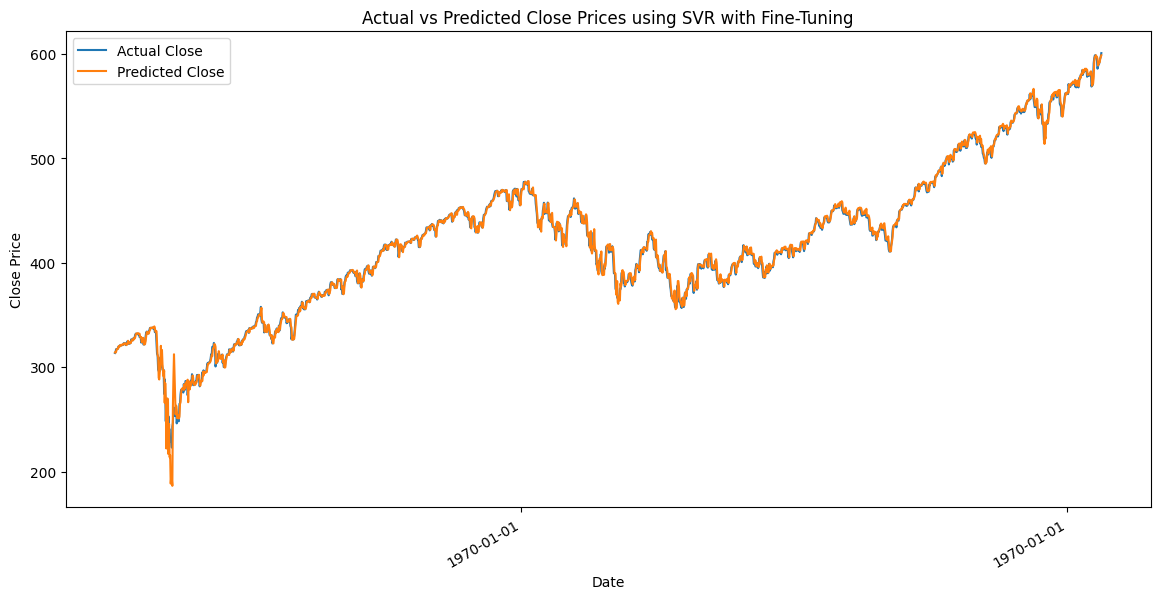

In [12]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm

# Vectorized create_sequences function
def create_sequences(X, y, window=7):
    X = np.array(X)
    y = np.array(y)
    n_samples = X.shape[0] - window
    Xs = np.array([X[i:i+window].flatten() for i in range(n_samples)])
    ys = y[window:]
    return Xs, ys

# Combine features and target into one array
scaled_train_data = np.hstack((scaled_X_train, scaled_y_train.reshape(-1, 1)))
scaled_test_data = np.hstack((scaled_X_test, scaled_y_test.reshape(-1, 1)))

# Prepare the data with 7 days input and 1 day output
X_train_seq, y_train_seq = create_sequences(scaled_train_data, scaled_y_train, window=7)
X_test_seq, y_test_seq = create_sequences(scaled_test_data, scaled_y_test, window=7)

# Define a TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Set up the parameter grid for SVR
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'epsilon': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'tol': [1e-2]
}

# Initialize SVR
linear_svr = LinearSVR()

# Custom GridSearchCV with tqdm
class TQDMGridSearchCV(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        n_candidates = len(self.param_grid['C']) * len(self.param_grid['epsilon']) * len(self.param_grid['tol'])
        self._tqdm = tqdm(total=n_candidates, desc="GridSearchCV")
        super().fit(X, y, **fit_params)
        self._tqdm.close()
        return self

    def _fit_and_score(self, estimator, X, y, scorer, train, test, verbose, parameters, fit_params, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=False, return_estimator=False, error_score='raise'):
        self._tqdm.update(1)
        return super()._fit_and_score(estimator, X, y, scorer, train, test, verbose, parameters, fit_params, return_train_score, return_parameters, return_n_test_samples, return_times, return_estimator, error_score)

# Set up GridSearchCV with tqdm
grid_search = GridSearchCV(
    estimator=linear_svr,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_seq, y_train_seq.ravel())

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train SVR with best parameters
best_svr = grid_search.best_estimator_

# Make predictions
train_predictions_scaled = best_svr.predict(X_train_seq)
test_predictions_scaled = best_svr.predict(X_test_seq)

# Inverse transform predictions
train_predictions = target_scaler.inverse_transform(train_predictions_scaled.reshape(-1, 1))
test_predictions = target_scaler.inverse_transform(test_predictions_scaled.reshape(-1, 1))
y_train_actual = target_scaler.inverse_transform(y_train_seq.reshape(-1, 1))
y_test_actual = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

# Create a DataFrame for plotting
dates_train_seq = train_df.index[7:]  # Adjusted for window size
dates_test_seq = test_df.index[7:]    # Adjusted for window size

train_pred_df = pd.DataFrame({
    'Date': dates_train_seq,
    'Actual_Close': y_train_actual.flatten(),
    'Predicted_Close': train_predictions.flatten()
})

test_pred_df = pd.DataFrame({
    'Date': dates_test_seq,
    'Actual_Close': y_test_actual.flatten(),
    'Predicted_Close': test_predictions.flatten()
})

# Plot Actual vs Predicted Close Prices for test set

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot Actual vs Predicted Close Prices for test set
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(test_pred_df['Date']), test_pred_df['Actual_Close'], label='Actual Close')
plt.plot(pd.to_datetime(test_pred_df['Date']), test_pred_df['Predicted_Close'], label='Predicted Close')

# Format the x-axis to show dates properly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices using SVR with Fine-Tuning')
plt.legend()
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.show()

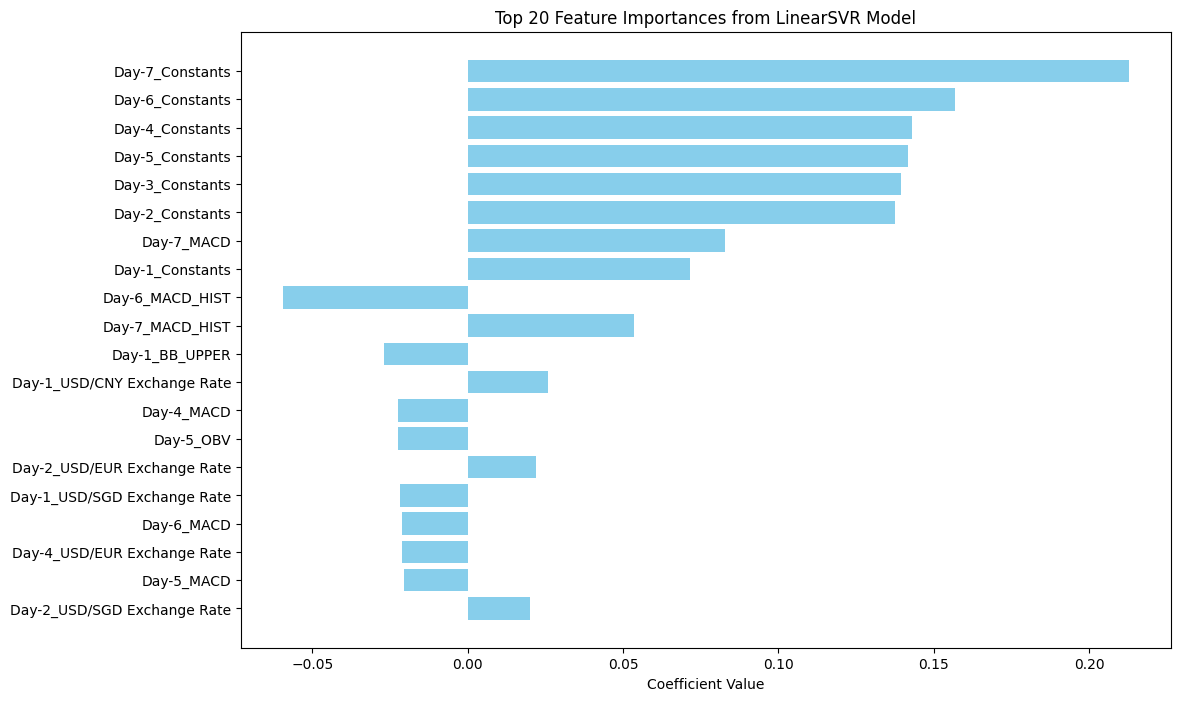

In [16]:
# if isinstance(feature_cols, pd.Index):
#     feature_cols = feature_cols.tolist()

# # Step 2: Append 'Feature_70' to the list
# feature_cols.append('Constants')
# print("Updated feature_cols:", feature_cols)

# Extract feature names from the windowed sequence
window_size = 7
feature_names = [f"Day-{i+1}_{feature}" for i in range(window_size) for feature in feature_cols]

# Extract coefficients from the trained model
coefficients = best_svr.coef_

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Calculate absolute coefficients for sorting
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Sort by absolute coefficient and select top 10
top_10_coef = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)

# Plot the top 10 feature importances
plt.figure(figsize=(12, 8))
plt.barh(top_10_coef['Feature'], top_10_coef['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Top 20 Feature Importances from LinearSVR Model')
plt.gca().invert_yaxis()  # Highest coefficient at the top
plt.show()

In [14]:
feature_cols

Index(['Volume', 'Crude Oil WTI Futures', 'Federal Funds Rate',
       'USD/EUR Exchange Rate', 'USD/GBP Exchange Rate',
       'USD/CNY Exchange Rate', 'USD/NOK Exchange Rate',
       'USD/SGD Exchange Rate', 'USD/AUD Exchange Rate',
       'USD/JPY Exchange Rate', 'USD/INR Exchange Rate',
       'Producer Price Index (PPI)', 'Unemployment Rate', 'Eight_Trigram_Code',
       'Inter_Day_Movement_Code', 'Volume_ROC', 'BB_UPPER', 'ADX_10', 'CCI_10',
       'MACD', 'MACD_HIST', 'MFI_10', 'ROC_10', 'WILLR_10', 'ULTOSC', 'BOP',
       'OBV', 'ADOSC', 'ATR_10', 'NATR_10', 'TRANGE', 'Return',
       'Rolling_Std_10', 'Rolling_Std_5'],
      dtype='object')

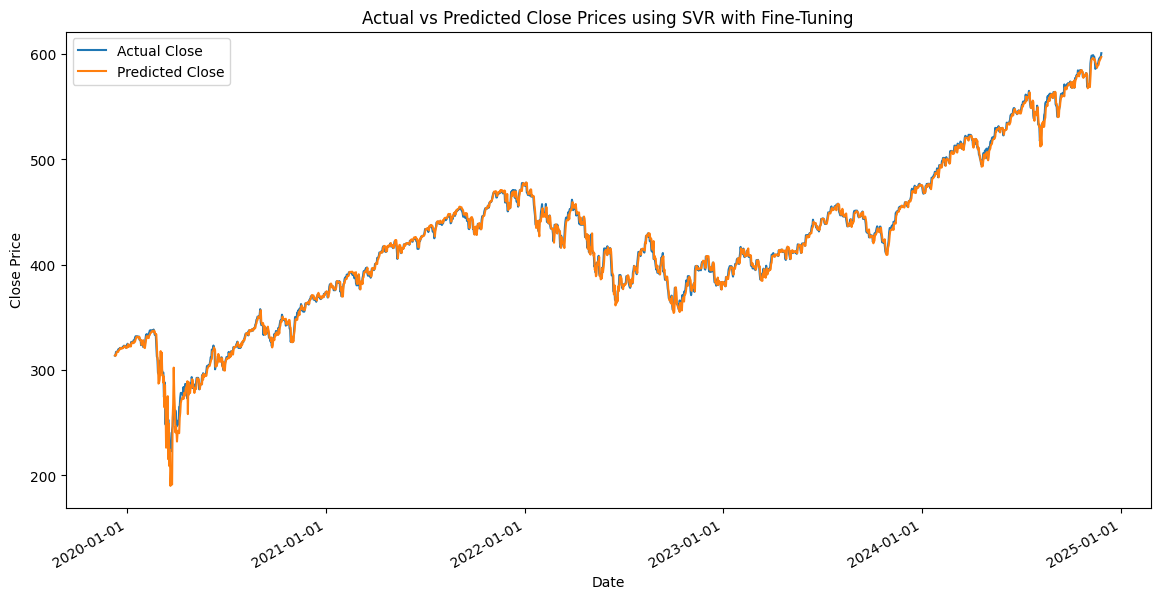

In [68]:
# Plot Actual vs Predicted Close Prices for test set

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot Actual vs Predicted Close Prices for test set
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(test_pred_df['Date']), test_pred_df['Actual_Close'], label='Actual Close')
plt.plot(pd.to_datetime(test_pred_df['Date']), test_pred_df['Predicted_Close'], label='Predicted Close')

# Format the x-axis to show dates properly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices using SVR with Fine-Tuning')
plt.legend()
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.show()

In [50]:
# Print start and end dates of training set
print(f"Training set starts on: {train_df.index[0]}, ends on: {train_df.index[-1]}")

# Print start and end dates of test set
print(f"Test set starts on: {test_df.index[0]}, ends on: {test_df.index[-1]}")

# Print start and end dates of training sequences
print(f"Training sequences start on: {dates_train_seq[0]}, end on: {dates_train_seq[-1]}")

# Print start and end dates of test sequences
print(f"Test sequences start on: {dates_test_seq[0]}, end on: {dates_test_seq[-1]}")

Training set starts on: 0, ends on: 7249
Test set starts on: 7250, ends on: 9062
Training sequences start on: 7, end on: 7249
Test sequences start on: 7257, end on: 9062


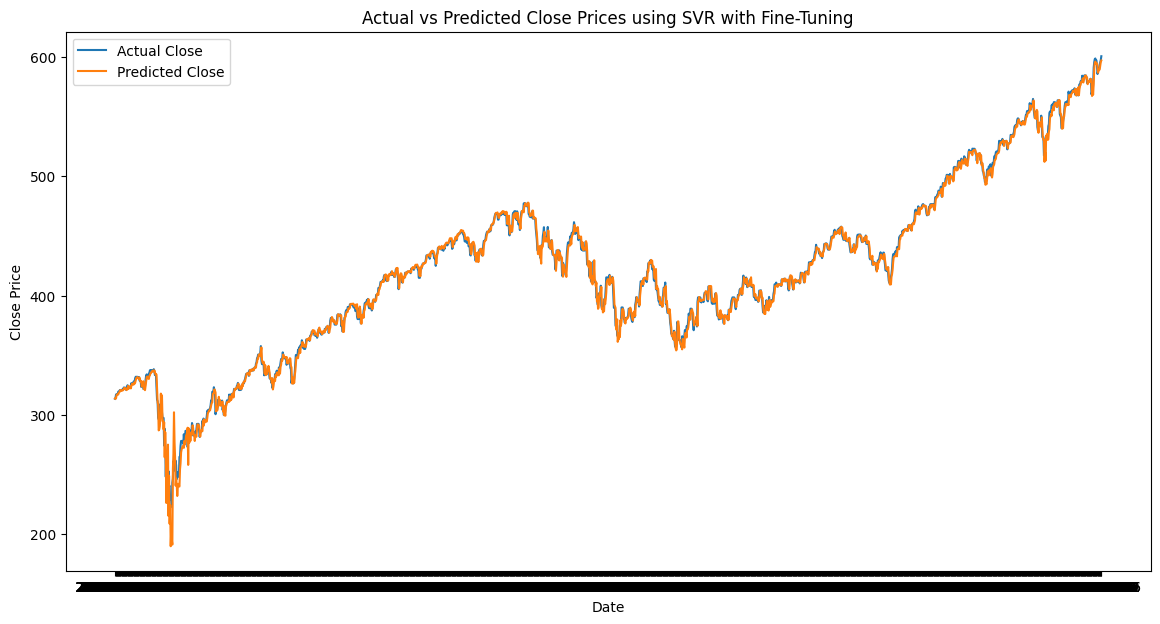

In [65]:
# Plot Actual vs Predicted Close Prices for test set
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(test_pred_df['Date'], test_pred_df['Actual_Close'], label='Actual Close')
plt.plot(test_pred_df['Date'], test_pred_df['Predicted_Close'], label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices using SVR with Fine-Tuning')
plt.legend()
plt.show()

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

# Prepare the data with 7 days input and 1 day output
def create_sequences(X, y, window=7):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window].flatten())
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

# Combine features and target into one array
scaled_train_data = np.hstack((scaled_X_train, scaled_y_train.reshape(-1, 1)))
scaled_test_data = np.hstack((scaled_X_test, scaled_y_test.reshape(-1, 1)))

# Create sequences
X_train_seq, y_train_seq = create_sequences(scaled_train_data, scaled_y_train, window=7)
X_test_seq, y_test_seq = create_sequences(scaled_test_data, scaled_y_test, window=7)

# Define a TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Set up the parameter grid for SVR
param_grid = {
    'C': [10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'max_iter': [-1],
    'kernel': ['linear']
}

# Initialize SVR
svr = SVR()

# Custom GridSearchCV with tqdm
class TQDMGridSearchCV(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        n_candidates = len(self.param_grid['C']) * len(self.param_grid['epsilon']) * len(self.param_grid['tol']) * len(self.param_grid['max_iter']) * len(self.param_grid['kernel'])
        self._tqdm = tqdm(total=n_candidates, desc="GridSearchCV")
        super().fit(X, y, **fit_params)
        self._tqdm.close()
        return self

    def _fit_and_score(self, estimator, X, y, scorer, train, test, verbose, parameters, fit_params, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=False, return_estimator=False, error_score='raise'):
        self._tqdm.update(1)
        return super()._fit_and_score(estimator, X, y, scorer, train, test, verbose, parameters, fit_params, return_train_score, return_parameters, return_n_test_samples, return_times, return_estimator, error_score)

# Set up GridSearchCV with tqdm
grid_search = TQDMGridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_seq, y_train_seq.ravel())

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train SVR with best parameters
best_svr = grid_search.best_estimator_

# Make predictions
train_predictions_scaled = best_svr.predict(X_train_seq)
test_predictions_scaled = best_svr.predict(X_test_seq)

# Inverse transform predictions
train_predictions = target_scaler.inverse_transform(train_predictions_scaled.reshape(-1, 1))
test_predictions = target_scaler.inverse_transform(test_predictions_scaled.reshape(-1, 1))
y_train_actual = target_scaler.inverse_transform(y_train_seq.reshape(-1, 1))
y_test_actual = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

# Create a DataFrame for plotting
dates_train_seq = train_df.index[7:]  # Adjusted for window size
dates_test_seq = test_df.index[7:]    # Adjusted for window size

train_pred_df = pd.DataFrame({
    'Date': dates_train_seq,
    'Actual_Close': y_train_actual.flatten(),
    'Predicted_Close': train_predictions.flatten()
})

test_pred_df = pd.DataFrame({
    'Date': dates_test_seq,
    'Actual_Close': y_test_actual.flatten(),
    'Predicted_Close': test_predictions.flatten()
})

# Plot Actual vs Predicted Close Prices for test set

plt.figure(figsize=(14, 7))
plt.plot(test_pred_df['Date'], test_pred_df['Actual_Close'], label='Actual Close')
plt.plot(test_pred_df['Date'], test_pred_df['Predicted_Close'], label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices using SVR with Fine-Tuning')
plt.legend()
plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV:   0%|          | 0/24 [00:36<?, ?it/s]


Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
Train RMSE: 1.1996
Test RMSE: 194.0372


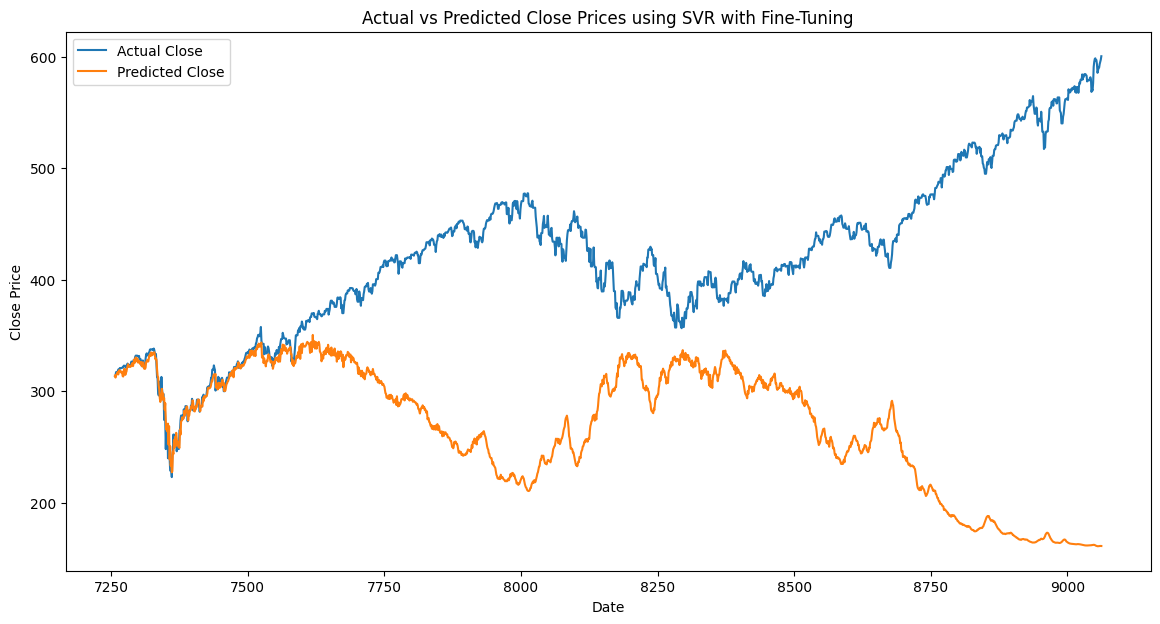

In [27]:
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
# from sklearn.base import clone

# Prepare the data with 7 days input and 1 day output
def create_sequences(X, y, window=7):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window].flatten())
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

# Combine features and target into one array
scaled_train_data = np.hstack((scaled_X_train, scaled_y_train.reshape(-1, 1)))
scaled_test_data = np.hstack((scaled_X_test, scaled_y_test.reshape(-1, 1)))

# Create sequences
X_train_seq, y_train_seq = create_sequences(scaled_train_data, scaled_y_train, window=7)
X_test_seq, y_test_seq = create_sequences(scaled_test_data, scaled_y_test, window=7)

# Define a TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Set up the parameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['rbf']
}
# param_grid = {
#     'C': [1],
#     'gamma': ['auto'],
#     'epsilon': [1],
#     'kernel': ['rbf', 'linear']
# }

# Initialize SVR
svr = SVR()

# Custom GridSearchCV with tqdm
class TQDMGridSearchCV(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        n_candidates = len(self.param_grid['C']) * len(self.param_grid['gamma']) * len(self.param_grid['epsilon']) * len(self.param_grid['kernel'])
        self._tqdm = tqdm(total=n_candidates, desc="GridSearchCV")
        super().fit(X, y, **fit_params)
        self._tqdm.close()
        return self

    def _fit_and_score(self, estimator, X, y, scorer, train, test, verbose, parameters, fit_params, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=False, return_estimator=False, error_score='raise'):
        self._tqdm.update(1)
        return super()._fit_and_score(estimator, X, y, scorer, train, test, verbose, parameters, fit_params, return_train_score, return_parameters, return_n_test_samples, return_times, return_estimator, error_score)

# Set up GridSearchCV with tqdm
grid_search = TQDMGridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_seq, y_train_seq.ravel())

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train SVR with best parameters
best_svr = grid_search.best_estimator_

# Make predictions
train_predictions_scaled = best_svr.predict(X_train_seq)
test_predictions_scaled = best_svr.predict(X_test_seq)

# Inverse transform predictions
train_predictions = target_scaler.inverse_transform(train_predictions_scaled.reshape(-1, 1))
test_predictions = target_scaler.inverse_transform(test_predictions_scaled.reshape(-1, 1))
y_train_actual = target_scaler.inverse_transform(y_train_seq.reshape(-1, 1))
y_test_actual = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

# Create a DataFrame for plotting
dates_train_seq = train_df.index[7:]  # Adjusted for window size
dates_test_seq = test_df.index[7:]    # Adjusted for window size

train_pred_df = pd.DataFrame({
    'Date': dates_train_seq,
    'Actual_Close': y_train_actual.flatten(),
    'Predicted_Close': train_predictions.flatten()
})

test_pred_df = pd.DataFrame({
    'Date': dates_test_seq,
    'Actual_Close': y_test_actual.flatten(),
    'Predicted_Close': test_predictions.flatten()
})

# Plot Actual vs Predicted Close Prices for test set
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(test_pred_df['Date'], test_pred_df['Actual_Close'], label='Actual Close')
plt.plot(test_pred_df['Date'], test_pred_df['Predicted_Close'], label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices using SVR with Fine-Tuning')
plt.legend()
plt.show()